# YOLOv8 Licence Plate Character Train and Predict

In [5]:
!rm -rf 

In [6]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 32.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6013.4/8062.4 GB disk)


# Check Annotation Data// tạo tập file ảnh

In [11]:
ipaths=[]
tpaths=[]
file_tail = ['.jpg']
for dirname, _, filenames in os.walk('/kaggle/input/dataset-pla'):
    for filename in filenames:
        if filename[-4:] in file_tail:
            ipaths.append(os.path.join(dirname, filename))
        elif filename[-4:]=='.txt':
            tpaths.append(os.path.join(dirname, filename))
ipaths=sorted(ipaths)
tpaths=sorted(tpaths)
print(ipaths[0])
print(len(ipaths))

/kaggle/input/dataset-pla/dataset/0000_00532_b.jpg
2490


In [12]:
boxdata=[]
boxfile=[]
for i in range(len(tpaths)):
    file=tpaths[i]
    boxdata+=[np.loadtxt(file)]     
    boxfile+=[file[0:-4].split(' ')[-1]]
print(boxdata[0])

[          0     0.38453     0.34653     0.20127     0.25083]


In [13]:
BOX=pd.DataFrame()

for i in range(len(boxdata)):
    if type(boxdata[i][0])==np.float64:
        add=pd.DataFrame([boxdata[i]])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])
    else:
        add=pd.DataFrame(boxdata[i])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])       

BOX2=BOX.reset_index(drop=True)
display(BOX2)
print(BOX2.iloc[:,0].max())

,0,1,2,3,4,5
0,0.0,0.384534,0.346535,0.201271,0.250825,/kaggle/input/dataset-pla/dataset/0000_00532_b
1,0.0,0.455508,0.506601,0.216102,0.267327,/kaggle/input/dataset-pla/dataset/0000_02187_b
2,0.0,0.488347,0.189769,0.201271,0.260726,/kaggle/input/dataset-pla/dataset/0000_05696_b
3,0.0,0.415254,0.381188,0.228814,0.293729,/kaggle/input/dataset-pla/dataset/0000_06886_b
4,0.0,0.469280,0.361386,0.192797,0.260726,/kaggle/input/dataset-pla/dataset/0000_08244_b
...,...,...,...,...,...,...
2485,0.0,0.429025,0.435644,0.112288,0.151815,/kaggle/input/dataset-pla/dataset/95
2486,0.0,0.556144,0.486799,0.133475,0.161716,/kaggle/input/dataset-pla/dataset/96
2487,0.0,0.478814,0.541254,0.148305,0.165017,/kaggle/input/dataset-pla/dataset/97
2488,0.0,0.539195,0.376238,0.112288,0.158416,/kaggle/input/dataset-pla/dataset/98


0.0


In [14]:
#gắn label cho biển số
N = list(range(1))
Name = ["Bien so xe"]

class_map = dict(zip(N, Name))
print(class_map)

{0: 'Bien so xe'}


In [15]:
#thêm label vào box
for i in range(len(BOX2)):
    BOX2.iloc[i,0]=class_map[int(BOX2.iloc[i,0])]
display(BOX2)
display(BOX2.iloc[:,0].value_counts())

/tmp/ipykernel_23/269172679.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Bien so xe' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  BOX2.iloc[i,0]=class_map[int(BOX2.iloc[i,0])]


,0,1,2,3,4,5
0,Bien so xe,0.384534,0.346535,0.201271,0.250825,/kaggle/input/dataset-pla/dataset/0000_00532_b
1,Bien so xe,0.455508,0.506601,0.216102,0.267327,/kaggle/input/dataset-pla/dataset/0000_02187_b
2,Bien so xe,0.488347,0.189769,0.201271,0.260726,/kaggle/input/dataset-pla/dataset/0000_05696_b
3,Bien so xe,0.415254,0.381188,0.228814,0.293729,/kaggle/input/dataset-pla/dataset/0000_06886_b
4,Bien so xe,0.469280,0.361386,0.192797,0.260726,/kaggle/input/dataset-pla/dataset/0000_08244_b
...,...,...,...,...,...,...
2485,Bien so xe,0.429025,0.435644,0.112288,0.151815,/kaggle/input/dataset-pla/dataset/95
2486,Bien so xe,0.556144,0.486799,0.133475,0.161716,/kaggle/input/dataset-pla/dataset/96
2487,Bien so xe,0.478814,0.541254,0.148305,0.165017,/kaggle/input/dataset-pla/dataset/97
2488,Bien so xe,0.539195,0.376238,0.112288,0.158416,/kaggle/input/dataset-pla/dataset/98


0
Bien so xe    2490
Name: count, dtype: int64

In [16]:
def draw_box(n0):
    
    ipath=ipaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath[0:-4].split('/')[-1]
    
    if BOX2[BOX2[5]==file] is not None:
        box=BOX2[BOX2[5]==file]
        box=box.reset_index(drop=True)

        for i in range(len(box)):
            label=box.iloc[i,0]
            x=box.iloc[i,1]
            y=box.iloc[i,2]
            w=box.iloc[i,3] 
            h=box.iloc[i,4]
            x0=((x-w/2)*W).astype(int)
            y0=((y-h/2)*H).astype(int)
            x1=((x+w/2)*W).astype(int)
            y1=((y+h/2)*H).astype(int)
            cv2.rectangle(image,(x0,y0),(x1,y1),(0,255,0),1) #green

    #plt.imshow(image)
    #plt.show()
    
    return image

In [17]:
images1=[]
for i in tqdm(range(len(ipaths))):#
    images1+=[draw_box(i)]

100%|██████████| 2490/2490 [00:15<00:00, 161.07it/s]


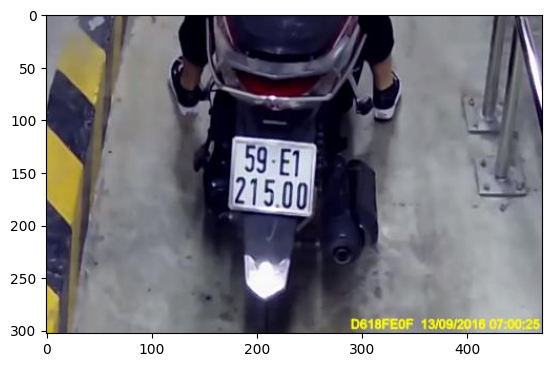

In [18]:
import matplotlib.pyplot  as plt
import cv2
plt.imshow(cv2.cvtColor(images1[1],cv2.COLOR_BGR2RGB))


In [19]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [20]:
def create_animation(ims):    
    fig=plt.figure(figsize=(10,6))
    #plt.axis('off')
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    plt.close()    
    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        return [im]
    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000//4)

In [18]:
# create_animation(images1)

# Split Train, Valid and Test

In [21]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

In [22]:
for i in range(len(ipaths)):
    ipath=ipaths[i]
    ifile=ipath.split('/')[-1]
    tpath=tpaths[i]
    tfile=tpath.split('/')[-1]
    if i%4==1:
        copyfile(ipath, f'datasets/valid/{ifile}')
        copyfile(tpath, f'datasets/valid/{tfile}')
    elif i%4==2:
        copyfile(ipath, f'datasets/test/{ifile}')
        #copyfile(tpath, f'datasets/test/{tfile}') 
    else:
        copyfile(ipath, f'datasets/train/{ifile}')
        copyfile(tpath, f'datasets/train/{tfile}')

In [23]:
file_count = 0

# Walk through the directory
for dirname, _, filenames in os.walk('/kaggle/working/datasets/train'):
    file_count += len(filenames)

print(file_count)
print(len(ipaths))

2490
2490


# Create yaml file 

In [24]:
import yaml

plate_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =1,
    names = Name
)

with open('plate.yaml', 'w') as outfile:
    yaml.dump(plate_yaml, outfile, default_flow_style=True)
    
%cat plate.yaml

{names: [Bien so xe], nc: 1, test: test, train: train, val: valid}


# Train

In [25]:
model = YOLO("yolov8x.pt") 

100%|██████████| 131M/131M [00:01<00:00, 92.9MB/s] 


In [24]:
# !yolo task=detect mode=train model=yolov8x.pt data=plate.yaml epochs=40 imgsz=640

# Result of Training

In [25]:
# tpaths2=[]
# for dirname, _, filenames in os.walk('/kaggle/working/runs/detect/train'):
#     for filename in filenames:
#         if filename[-4:]=='.jpg':
#             tpaths2+=[(os.path.join(dirname, filename))]
# tpaths2=sorted(tpaths2)
# print(tpaths2[0])

In [26]:
# from PIL import Image
# import matplotlib.pyplot as plt
# print(tpaths2)
# # Open the image from a file
# image = Image.open(tpaths2[2])

# plt.imshow(image)
# plt.title('Original Image')
# plt.axis('off')  # Hide the axis
# plt.show()


In [27]:
# for path in tpaths2:
#     image = Image.open(path)
#     image=np.array(image)
#     plt.figure(figsize=(20,10))
#     plt.imshow(image)
#     plt.show()

# Predict

In [27]:
best_path0='/kaggle/input/bestpt/best.pt'
source0='/kaggle/working/datasets/test'

In [28]:
!ls

datasets  plate.yaml  yolov8x.pt


In [29]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
# print(ppaths)

In [30]:
model2 = YOLO(best_path0)

In [31]:
!yolo task=detect mode=predict model={best_path0} conf=0.01 source={source0}

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 268 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs

image 1/622 /kaggle/working/datasets/test/0000_05696_b.jpg: 416x640 2 00s, 42.6ms
image 2/622 /kaggle/working/datasets/test/0002_02183_b.jpg: 416x640 1 00, 29.3ms
image 3/622 /kaggle/working/datasets/test/0004_06801_b.jpg: 416x640 1 00, 29.2ms
image 4/622 /kaggle/working/datasets/test/0006_05286_b.jpg: 416x640 1 00, 28.4ms
image 5/622 /kaggle/working/datasets/test/0007_05159_b.jpg: 416x640 1 00, 26.8ms
image 6/622 /kaggle/working/datasets/test/0010_00004_b.jpg: 416x640 2 00s, 26.8ms
image 7/622 /kaggle/working/datasets/test/0013_05647_b.jpg: 416x640 1 00, 26.8ms
image 8/622 /kaggle/working/datasets/test/0019_01137_b.jpg: 416x640 1 00, 26.6ms
image 9/622 /kaggle/working/datasets/test/0020_02063_b.jpg: 416x640 1 00, 26.5ms
image 10/622 /kaggle/working/datasets/test/0023_05798_b.jpg: 416x640 1 00, 26.5ms
image 11/622 /

# Result of Prediction

In [40]:
source0='/kaggle/input/data-test2'
# source0 = '/kaggle/input/data-test3'
results = model2.predict(source0,conf=0.01)
print(len(results))


image 1/5 /kaggle/input/data-test2/anh1.jpg: 480x640 1 00, 31.7ms
image 2/5 /kaggle/input/data-test2/anh2.jpg: 640x480 4 00s, 41.2ms
image 3/5 /kaggle/input/data-test2/anh4.jpg: 480x640 (no detections), 32.3ms
image 4/5 /kaggle/input/data-test2/anh5.jpg: 416x640 1 00, 29.9ms
image 5/5 /kaggle/input/data-test2/anh8.jpg: 480x640 5 00s, 32.4ms
Speed: 2.2ms preprocess, 33.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
5


In [41]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)

In [42]:
print(len(results), len(ppaths))

PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):#len(results)
    if len(results[i].boxes.data)>0:
        arri=pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
        path=ppaths[i]
        file=path.split('/')[-1]
        arri=arri.assign(file=file)
        arri=arri.assign(i=i)
        PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

5 5


/tmp/ipykernel_23/1334352090.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  PBOX=pd.concat([PBOX,arri],axis=0)


,x,y,x2,y2,confidence,class,file,i
0,162.199219,224.444290,275.716797,312.654907,0.811224,0.0,anh1.jpg,0.0
0,123.202835,520.199341,375.084839,719.285522,0.858977,0.0,anh2.jpg,1.0
1,409.439301,611.235779,443.092072,639.471985,0.049312,0.0,anh2.jpg,1.0
2,37.955154,929.351257,263.640808,959.903870,0.032657,0.0,anh2.jpg,1.0
3,408.335327,611.105408,441.308289,651.522522,0.014167,0.0,anh2.jpg,1.0
0,222.639389,151.426514,333.609039,241.047424,0.862866,0.0,anh5.jpg,3.0
0,301.227722,257.043213,357.871643,300.495148,0.850277,0.0,anh8.jpg,4.0
1,428.182861,263.833130,484.214630,306.259918,0.849249,0.0,anh8.jpg,4.0
2,12.011333,250.894272,77.715782,294.944824,0.843597,0.0,anh8.jpg,4.0
3,575.698059,273.412048,628.904114,314.492218,0.841409,0.0,anh8.jpg,4.0


In [43]:
PBOX['class']=PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX=PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

,x,y,x2,y2,confidence,class,file,i
0,162.199219,224.444290,275.716797,312.654907,0.811224,Bien so xe,anh1.jpg,0.0
1,123.202835,520.199341,375.084839,719.285522,0.858977,Bien so xe,anh2.jpg,1.0
2,409.439301,611.235779,443.092072,639.471985,0.049312,Bien so xe,anh2.jpg,1.0
3,37.955154,929.351257,263.640808,959.903870,0.032657,Bien so xe,anh2.jpg,1.0
4,408.335327,611.105408,441.308289,651.522522,0.014167,Bien so xe,anh2.jpg,1.0
5,222.639389,151.426514,333.609039,241.047424,0.862866,Bien so xe,anh5.jpg,3.0
6,301.227722,257.043213,357.871643,300.495148,0.850277,Bien so xe,anh8.jpg,4.0
7,428.182861,263.833130,484.214630,306.259918,0.849249,Bien so xe,anh8.jpg,4.0
8,12.011333,250.894272,77.715782,294.944824,0.843597,Bien so xe,anh8.jpg,4.0
9,575.698059,273.412048,628.904114,314.492218,0.841409,Bien so xe,anh8.jpg,4.0


class
Bien so xe    11
Name: count, dtype: int64

In [44]:
color_codes = [
    '#FF0000',  # Red
    '#FF4500',  # OrangeRed
    '#FF8C00',  # DarkOrange
    '#FFA500',  # Orange
    '#FFD700',  # Gold
    '#FFFF00',  # Yellow
    '#ADFF2F',  # GreenYellow
    '#7FFF00',  # Chartreuse
    '#00FF00',  # Lime
    '#00FA9A',  # MediumSpringGreen
    '#00FFFF',  # Cyan
    '#00BFFF',  # DeepSkyBlue
    '#0000FF',  # Blue
    '#8A2BE2'   # BlueViolet
]
colors=[]
for c in color_codes:
    colors += [tuple((int(c[1:3],16),int(c[3:5],16),int(c[5:7],16)))] 

In [45]:
# hamf 
def draw_box2(n0):
    
    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]
    
    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=box.iloc[i,5]
            x=int(box.iloc[i,0])
            y=int(box.iloc[i,1])
            x2=int(box.iloc[i,2])
            y2=int(box.iloc[i,3])
            #print(label,x,y,x2,y2)
            ci=colors[0]
            cv2.rectangle(image,(x,y),(x2,y2),ci,1)

    #plt.imshow(image)
    #plt.show()                   
                
    return image

In [46]:
images2=[]
for i in tqdm(range(len(ppaths)-1)):
    images2+=[draw_box2(i)]

100%|██████████| 4/4 [00:00<00:00, 180.97it/s]


In [47]:
create_animation(images2)

In [41]:
print(model2)0n8

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(400, 160, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-2): 3 x Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplac